<a href="https://colab.research.google.com/github/Jorbnc/MAIA-RL/blob/master/RL_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importaciones

In [10]:
# Para anotar los tipos de argumentos del tablero
from typing import Tuple, List

# Para toma de decisiones
import random
import numpy as np

# Tiempo de Aprendizaje
import time

# Para visualización
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation

from matplotlib.textpath import TextPath
from matplotlib.markers  import MarkerStyle
from matplotlib.path     import Path

# Tablero

In [11]:
#Validar que el número de celda esté dentro de los límites del tablero
def limites_validos(celda, celda_max) -> bool:
    return 1 <= celda <= celda_max

# Definición del ambiente
class Tablero:
    def __init__(
        self,
        nro_filas: int,
        nro_columnas: int,
        celda_victoria: int,
        celdas_perdida: List[int],
        celdas_escalera: List[Tuple[int]],
        celdas_rodadero: List[Tuple[int]],
    ):
        # ----------------------------------------------------------------------
        # Validación de condiciones mínimas para el tablero
        if nro_filas < 2 or nro_columnas < 2:
            raise ValueError("Debe haber al menos 2 filas y 2 columnas")
        # $N= Filas x Columnas representa el número total de casillas del tablero
        self.celda_max = nro_filas * nro_columnas
        celdas_a_validar = ([celda_victoria] + celdas_perdida
                            + [celda for par in celdas_escalera for celda in par]
                            + [celda for par in celdas_rodadero for celda in par]
                            )
        # Validamos las ubicaciones o estados dados por parámetros sean válidos
        for celda in celdas_a_validar:
            if not limites_validos(celda, self.celda_max):
                raise ValueError(f"{celda} fuera de los limites: {1} a {self.celda_max}")

        # Una celda de pérdida no puede ser una celda de victoria
        for c in celdas_perdida:
            if c == celda_victoria:
                raise ValueError(f"Estado de pérdida {c} debe ser diferente a estado de victoria {celda_victoria}")

        # ----------------------------------------------------------------------
        # Definición de Atributos
        self.nro_filas = nro_filas
        self.nro_columnas = nro_columnas
        self.celda_victoria = celda_victoria
        self.celdas_perdida = celdas_perdida
        self.celdas_escalera = celdas_escalera
        self.celdas_rodadero = celdas_rodadero

        # Mismo diccionario para las transiciones de las escaleras y de los rodaderos
        self.escaleras_y_rodaderos = {inicio: fin for inicio, fin in zip(
            # Inicio de escaleras y rodaderos
            [a for (a, b) in self.celdas_escalera] + [a for (a, b) in self.celdas_rodadero],
            # Fin de escaleras y rodaderos
            [b for (a, b) in self.celdas_escalera] + [b for (a, b) in self.celdas_rodadero]
        )}

        # Definición de la recompensa para: ganar o perder el juego
        self.reward_map = {
            self.celda_victoria: 1.0,
            **{cell: -1.0 for cell in self.celdas_perdida}
        }

    #Representación impresa del Tablero
    def __repr__(self) -> str:

        atributos = [
            ("Número de filas", self.nro_filas),
            ("Número de columnas", self.nro_columnas),
            ("Celda máxima", self.celda_max),
            ("Celda victoria", self.celda_victoria),
            ("Celdas perdida", self.celdas_perdida),
            ("Celdas escalera", self.celdas_escalera),
            ("Celdas rodadero", self.celdas_rodadero),
        ]
        atributos_str = "\n".join(f" {nombre}: {valor}" for nombre, valor in atributos)
        return f"Tablero:\n{atributos_str}\n"

    # Obtener coordenada (columna, fila) a partir del número de celda y el número de columnas
    def celda_a_coord(self, nro_celda) -> tuple[int, int]:

        # -1 para manejar los multiplos de 'nro_columnas'
        fila = ((nro_celda - 1) // self.nro_columnas) + 1
        offset = (nro_celda - 1) % self.nro_columnas

        # Fila impar
        if fila % 2 == 1:
            # Izquierda a derecha
            columna = offset + 1
        else:
            # Derecha a izquierda
            columna = self.nro_columnas - offset
        # Centrar
        return (columna - 0.5, fila - 0.5)

    #Obtener el número de celda a partir del par: (columna, fila)
    def coord_a_celda(self, col, fila) -> int:

        valor_inicial = (fila - (fila % 2)) * self.nro_columnas
        offset = (-1) ** (fila - 1) * (col - ((fila - 1) % 2))
        return valor_inicial + offset

    # Saber si el estado es terminal
    def is_terminal(self, estado) -> bool:
        return estado == self.celda_victoria or estado in self.celdas_perdida

# Para exportar/importar con `from Tablero import`
__all__ = ["limites_validos", "Tablero"]

# Agente

In [12]:
class AgenteQLearning: # Sugiero cambiar nombre para la primera entrega
    def __init__(self, tablero: Tablero, alpha: float = 0.1, gamma: float = 0.9, epsilon: float = 0.1):

        # Ambiente
        self.tablero = tablero

        # Parámetros del agente (algunos parámetros podrían ajustarse en la entrega final, por ahora se usan parámetros escogidos al azar)
        # Tasa de aprendizaje
        self.alpha = alpha
        # Factor de descuento
        self.gamma = gamma
        # Ratio de exploración
        self.epsilon = epsilon
        # Posición inicial siempre en 1
        self.pos = 1
        # Izquierda/Derecha o Avanzar/ Retroceder
        self.acciones = [-1, 1]

        # Q-table (o Q-dict en nuestro caso)
        self.Q = {}  # No va entrega parcial

    #Escoge una acción
    def escoger_accion(self, estado) -> int:

        # De de acá....
        # Exploración
        if random.random() < self.epsilon:
            return random.choice(self.acciones)

        # Explotación
        else:
            # Obtener los mejores valores Q (0 en caso aún no exista)
            Q_vals = [self.Q.get((estado, a), 0.0) for a in self.acciones]
            Q_max = max(Q_vals)

            # En caso de empate, escoger aleatoriamente una acción
            mejores_acciones = [a for a, Q in zip(self.acciones, Q_vals) if Q == Q_max]
            return random.choice(mejores_acciones)
          # Hasta acá no iría en la entrega parcial

        # Iría en la entrega parcial:
        # if self.tablero.is_terminal(estado):
        #   return None
        # else:
        #   return random.choice(self.acciones)


    # De de acá....
    def actualizar_Q(self, estado, accion, reward, estado_siguiente) -> None:
        """
        Actualización Q-learning con base en(Sₜ,Aₜ,Rₜ,Sₜ₊₁):
            Q(Sₜ,Aₜ) = Q(Sₜ,Aₜ) + α[Rₜ₊₁ + γ*maxₐ Q(Sₜ₊₁,a) - Q(Sₜ,Aₜ)]    (Sutton & Barto, p. 131)
        """
        Q_actual = self.Q.get((estado, accion), 0.0)

        # Estimar mejor Q en el siguiente estado
        Q_vals_siguiente_max = max([self.Q.get((estado_siguiente, a), 0.0) for a in self.acciones])

        # Actualización
        # TODO: Probar si hay cambios importantes al variar gamma
        self.Q[(estado, accion)] = Q_actual + self.alpha * (reward + self.gamma * Q_vals_siguiente_max - Q_actual)
    # Hasta acá no iría en la entrega parcial

    #Definición de función de transición
    def transicion(self, estado, accion):
        if accion != None:
          estado_siguiente = estado + accion

          estado_siguiente = self.tablero.escaleras_y_rodaderos.get(
              # Si el estado_siguiente es el inicio de una escalera/rodadero, entonces retorna el final
              estado_siguiente,
              # En caso contrario, solo valida el estado_siguiente
              max(1, min(estado_siguiente, self.tablero.celda_max))
          )
          # Aclaración: No se evalua condición de terminación. Esto será manejado la fase de simulación
          return estado_siguiente
        else:
          return estado

    #Función de recompensa basado en un mapeo (diccionario): Sₜ₊₁ -> reward
    def reward(self, estado_siguiente):
        return self.tablero.reward_map.get(estado_siguiente, 0)


    #Representa un paso en la simulación con base en las condiciones actuales.
    #Actualiza la Q-table con base en (Sₜ,Aₜ,Rₜ,Sₜ₊₁) y retorna la tupla. # No va entrega parcial

    def step(self) -> Tuple[int, int, float, int]:
        estado = self.pos
        accion = self.escoger_accion(estado)

        # Transición y Reward del paso actual
        estado_siguiente = self.transicion(estado, accion)
        reward = self.reward(estado_siguiente)

        # Actualizar Q y estado (pos) # No va entrega parcial
        self.actualizar_Q(estado, accion, reward, estado_siguiente) # No va entrega parcial
        self.pos = estado_siguiente

        return estado, accion, reward, estado_siguiente

# Visualización

In [13]:
# Plotear el tablero, se mostrará una animación con el recorrido del agente.
def plot_tablero(tablero, trayectoria=None) -> None:

    nro_filas, nro_columnas = tablero.nro_filas, tablero.nro_columnas

    fig, ax = plt.subplots(figsize=(nro_columnas, nro_filas), dpi=75)
    ax.set_xlim(0, nro_columnas)
    ax.set_ylim(0, nro_filas)
    ax.set_xticks(range(1, nro_columnas + 1))
    ax.set_yticks(range(1, nro_filas + 1))
    ax.grid(color="black", linewidth=1)
    ax.tick_params(
        axis="both", which="both",
        bottom=False, top=False, left=False, right=False,
        labelbottom=False, labelleft=False,
    )

    # Anotar el número de celda
    for fila in range(1, nro_filas + 1):
        for col in range(1, nro_columnas + 1):
            nro_celda = tablero.coord_a_celda(col, fila)
            ax.text(col - 0.5, fila - 0.35, str(nro_celda), ha="center", va="bottom", alpha=0.5)

    # Posición de victoria
    vic_coord = tablero.celda_a_coord(tablero.celda_victoria)
    ax.text(*vic_coord, "FIN", ha="center", va="top", color="green", size=15)

    # Posiciones de pérdida
    skull_path   = TextPath((0, 0), '\N{SKULL AND CROSSBONES}', size=1)
    skull_marker = MarkerStyle(Path(skull_path.vertices, skull_path.codes))
    for celda in tablero.celdas_perdida:
        ax.scatter(*tablero.celda_a_coord(celda), color="red", s=150, marker= skull_marker)

    # Escaleras
    for par in tablero.celdas_escalera:
        x1, y1 = tablero.celda_a_coord(par[0])
        x2, y2 = tablero.celda_a_coord(par[1])
        arrow = mpatches.FancyArrow(x1, y1, x2 - x1, y2 - y1,
                                    width=0.08, length_includes_head=True,
                                    color="green", alpha=0.5)
        ax.add_patch(arrow)

    # Rodaderos
    for par in tablero.celdas_rodadero:
        x1, y1 = tablero.celda_a_coord(par[0])
        x2, y2 = tablero.celda_a_coord(par[1])
        arrow = mpatches.FancyArrow(x1, y1, x2 - x1, y2 - y1,
                                    width=0.08, length_includes_head=True,
                                    color="red", alpha=0.5)
        ax.add_patch(arrow)

    # Animar trayectoria
    if trayectoria:
        # Figura del agente. Se actualiza iterativamente
        dot, = ax.plot([], [], 'bo', markersize=12)

        def actualizar_frame(frame):
            coord = tablero.celda_a_coord(trayectoria[frame])
            dot.set_data([coord[0]], [coord[1]])
            # tuple (con 1 solo elemento) para que FuncAnimation pueda 'iterar' y re-dibujar el dot
            return dot,

        anim = animation.FuncAnimation(
            fig,
            # Función para llamar por cada frame
            actualizar_frame,
            # Total de frames
            frames=len(trayectoria),
            interval=200,
            # loopear la animación
            repeat=True,
            # re-dibujar solo figuras que han cambiado
            blit=True,
        )

    plt.show()

# Simulación

In [14]:
#Correr simulación y plotear la última trayectoria
def run(tablero, agente, episodios=1000) -> None:

    reward_acumulado = []

    for episodio in range(episodios):
        # Reiniciar condiciones al inicio de cada episodio
        agente.pos = 1
        trayectoria = [agente.pos]
        pasos = 0

        # Recorrer tablero
        while True:
            estado, accion, reward, estado_siguiente = agente.step()
            pasos += 1
            trayectoria.append(estado_siguiente)
            reward_acumulado.append(reward)

            # Evaluar si hay condición de finalización
            if estado_siguiente == agente.tablero.celda_victoria or estado_siguiente in agente.tablero.celdas_perdida:
                print(f"Episodio {episodio + 1} terminó en {pasos} pasos, con reward {reward}.")
                break

    plot_tablero(tablero, trayectoria)

# Main

Episodio 1 terminó en 218 pasos, con reward -1.0.
Episodio 2 terminó en 191 pasos, con reward -1.0.
Episodio 3 terminó en 77 pasos, con reward -1.0.
Episodio 4 terminó en 449 pasos, con reward 1.0.
Episodio 5 terminó en 169 pasos, con reward -1.0.
Episodio 6 terminó en 566 pasos, con reward 1.0.
Episodio 7 terminó en 617 pasos, con reward 1.0.
Episodio 8 terminó en 32 pasos, con reward -1.0.
Episodio 9 terminó en 206 pasos, con reward 1.0.
Episodio 10 terminó en 281 pasos, con reward -1.0.
Episodio 11 terminó en 529 pasos, con reward 1.0.
Episodio 12 terminó en 462 pasos, con reward -1.0.
Episodio 13 terminó en 53 pasos, con reward -1.0.
Episodio 14 terminó en 188 pasos, con reward 1.0.
Episodio 15 terminó en 176 pasos, con reward -1.0.
Episodio 16 terminó en 586 pasos, con reward 1.0.
Episodio 17 terminó en 159 pasos, con reward -1.0.
Episodio 18 terminó en 294 pasos, con reward 1.0.
Episodio 19 terminó en 245 pasos, con reward 1.0.
Episodio 20 terminó en 244 pasos, con reward 1.0.
Ep

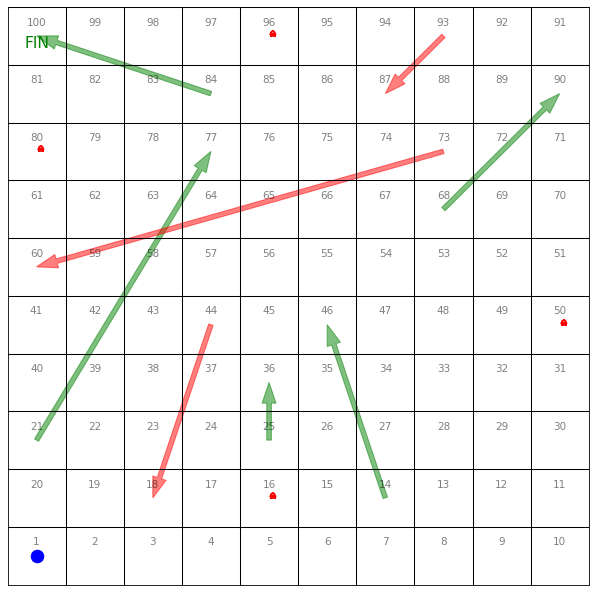

In [15]:
# Definición de un tablero adecuado para el problema
tab = Tablero(
    nro_filas=10,
    nro_columnas=10,
    celda_victoria=100,
    celdas_perdida=[16, 50, 80, 96],
    celdas_escalera=[(14, 46), (21, 77), (25, 36), (68, 90), (84, 100)],
    celdas_rodadero=[(44, 18), (73, 60), (93, 87)],
)
agente = AgenteQLearning(tab, epsilon=0.1, gamma=0.5)
run(tab, agente, episodios=100)